# Trabalho de conclusão de Curso
Treinamento das redes Alexnet, Densenet e Autoral 

# Configuração
Instalação dos seguintes pacotes
- Tensorflow 2.10
- Matplotlib
- Scipy
- Hyperopt

In [40]:
# %pip install tensorflow==2.10
# %pip install flwr
# %pip install matplotlib
# %pip install scipy
# %pip install hyperopt
# %pip install keras
# %pip install sklearn
# %pip install seaborn

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     --- --------------------------------- 30.7/294.9 kB 660.6 kB/s eta 0:00:01
     ---------- -------------------------- 81.9/294.9 kB 762.6 kB/s eta 0:00:01
     ------------------- ---------------- 163.8/294.9 kB 984.6 kB/s eta 0:00:01
     ------------------------------- ------ 245.8/294.9 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.6 MB ? eta -:--:--
     - -------------------------------------- 0.3/11.6 MB 3.9 MB/s eta 0:00:03
     - -------------------------------------- 0.5/11.6 MB 3.5 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/11.6 MB 6.1 MB/s eta 0:00:02
     ----- ---------------------------------- 1.6/11.6 MB 7.4 MB/s eta 0:00:02
     -------- ------------------------------- 2.3/11.6 MB 9.3 MB/s 


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Implementando

In [6]:
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, BatchNormalization, Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam

from hyperopt import fmin, tpe, hp,Trials,STATUS_OK;
import tensorflow as tf
import numpy as np;
from matplotlib import pyplot;

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
dataset_dir = './fer2013'
dt_train_dir = os.path.join(dataset_dir,'train')
dt_test_dir = os.path.join(dataset_dir,'test')

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dt_train_dir,
    target_size=(48,48),
    color_mode= "grayscale",
    batch_size= batch_size, 
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    dt_test_dir,
    target_size=(48,48),
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Alexnet

In [8]:
def Alexnet(learning_rate, initializer):
    model = Sequential()
    # kernel 3x3 strides 1x1 padding same
    # Layer 1: Convolutional layer with 64 filters of size 11x11x3
    model.add(Conv2D(filters=64, kernel_size=(4,4), kernel_initializer=initializer, strides=(2,2), padding='valid', activation='relu', input_shape=(48,48,1)))

    # Layer 2: Max pooling layer with pool size of 3x3
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
    model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 6: Fully connected layer with 4096 neurons
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    # Layer 7: Fully connected layer with 4096 neurons
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

## Densenet

In [9]:
def conv_block(x, growth_rate, name):
    """Constrói um bloco convolucional usado em uma DenseNet."""
    x1 = BatchNormalization(name=name + '_bn')(x)
    x1 = Activation('relu', name=name + '_relu')(x1)
    x1 = Conv2D(growth_rate, (3,3), padding='same', name=name + '_conv')(x1)
    x = Concatenate(name=name + '_concat')([x, x1])
    return x

def dense_block(x, num_conv, growth_rate, name):
    """Constrói um bloco denso, consistindo em vários blocos convolucionais."""
    for i in range(num_conv):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def transition_layer(x, reduction, name):
    """Constrói uma camada de transição para reduzir as dimensões."""
    x = BatchNormalization(name=name + '_bn')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1,1), padding='same', name=name + '_conv')(x)
    x = AveragePooling2D((2,2), strides=2, name=name + '_pool')(x)
    return x

def create_model(input_shape, num_blocks, num_conv_per_block, growth_rate, reduction, num_classes, initializer):
    """Constrói uma DenseNet."""
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7,7), strides=2, padding='same', name='initial_conv',kernel_initializer=initializer)(inputs)
    x = BatchNormalization(name='initial_bn')(x)
    x = Activation('relu', name='initial_relu')(x)
    x = AveragePooling2D((3,3), strides=2, padding='same', name='initial_pool')(x)
    
    for i in range(num_blocks):
        x = dense_block(x, num_conv_per_block, growth_rate, name='dense_block' + str(i + 1))
        if i != num_blocks - 1:  # Não adicionar camada de transição após o último bloco denso
            x = transition_layer(x, reduction, name='transition_layer' + str(i + 1))
    
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    outputs = Dense(num_classes, activation='softmax', name='fc')(x)
    
    return Model(inputs, outputs, name='densenet')

def DenseNet(learning_rate, initializer):
    # Exemplo de criação de uma DenseNet simplificada
    input_shape = (48, 48, 1)
    num_blocks = 3
    num_conv_per_block = 4
    growth_rate = 32
    reduction = 0.5
    num_classes = 7

    model = create_model(input_shape, num_blocks, num_conv_per_block, growth_rate, reduction, num_classes, initializer)
    #model.summary()
    model.compile(optimizer = Adam(learning_rate), loss = 'categorical_crossentropy', metrics =['accuracy'])

    return model


## Autoral

In [10]:
def Autoral(learning_rate,initializer):
    model = Sequential()

    # CNN LAYER 1
    model.add(Conv2D(input_shape =(48,48,1), filters =128, kernel_size =(3,3), padding = "same", activation = "relu", kernel_initializer=initializer))
    model.add(MaxPooling2D(pool_size =(2,2), strides =(2,2)))
    model.add(Dropout(0.5))
    # CNN LAYER 2
    model.add(Conv2D(filters =64, kernel_size =(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size= (2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    # DNN LAYER 1
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # DNN LAYER 2
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # DNN LAYER 3
    model.add(Dense(7, activation = 'softmax'))

    # OPT AND LR
    model.compile(optimizer = Adam(learning_rate), loss = 'categorical_crossentropy', metrics =['accuracy'])

    #model.summary()

    return model

# Hyperopt

In [11]:
def hyperopt(create_model):

    def objective(hyperparams):
        model = create_model(learning_rate=hyperparams['learning_rate'],initializer=hyperparams['weight_initialization'])
        result = model.fit(train_generator,
                        validation_data=validation_generator, 
                        epochs=hyperparams['epochs'], 
                        batch_size=hyperparams['batch_size'], 
                        verbose=0)
        val_loss = min(result.history['val_loss']) 
        
        return {'loss': val_loss, 'status': STATUS_OK} 
    
    batch_size_arr = [8, 16, 32, 64, 128]
    epochs_arr = [25, 50, 100, 150]
    weight_initialization_arr = ['glorot_uniform', 'he_normal', 'lecun_normal']

    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
        'batch_size': hp.choice('batch_size', batch_size_arr),
        'epochs': hp.choice('epochs', epochs_arr),
        'weight_initialization': hp.choice('weight_initialization', weight_initialization_arr) 
    }

    trials = Trials()
    best = fmin(objective,
                space=space,
                algo=tpe.suggest,
                max_evals=10, 
                trials=trials) 

    best_values = {
        'learning_rate' : best['learning_rate'],
        'batch_size':  batch_size_arr[best['batch_size']],
        'epochs': epochs_arr[best['epochs']], 
        'weight_initialization': weight_initialization_arr[best['weight_initialization']]
                   }
    
    print(best_values)

    return best_values, trials

In [12]:
best_alexnet, trials_alexnet = hyperopt(Alexnet)
np.save("fase_treinamento_2/trials_alex.npy", trials_alexnet.trials)
# dic = np.load(name, allow_pickle='TRUE')

100%|██████████| 10/10 [6:21:44<00:00, 2290.49s/trial, best loss: 1.0942326784133911]  
{'learning_rate': 0.000248422068699183, 'batch_size': 8, 'epochs': 150, 'weight_initialization': 'lecun_normal'}


In [13]:
best_densenet, trials_densenet = hyperopt(DenseNet)
np.save("fase_treinamento_2/trials_dense.npy", trials_densenet.trials)

100%|██████████| 10/10 [7:36:34<00:00, 2739.46s/trial, best loss: 1.0275566577911377] 
{'learning_rate': 0.0004337574711035279, 'batch_size': 16, 'epochs': 150, 'weight_initialization': 'he_normal'}


In [14]:
best_autoral, trials_autoral = hyperopt(Autoral)
np.save("fase_treinamento_2/trials_autoral.npy", trials_autoral.trials)

100%|██████████| 10/10 [6:07:48<00:00, 2206.89s/trial, best loss: 1.039408802986145]  
{'learning_rate': 0.00016716393601209385, 'batch_size': 16, 'epochs': 150, 'weight_initialization': 'glorot_uniform'}


# Treinamento

In [15]:
def treinar_model(model,best):
    history = model(best['learning_rate'],best['weight_initialization']).fit(
        train_generator,
        validation_data=validation_generator,
        batch_size=best['batch_size'],
        epochs=best['epochs'],
    )

    return history, model 

In [16]:
history_alexnet, model_alexnet = treinar_model(Alexnet, best_alexnet)

Epoch 1/150
898/898 [==============================] - 33s 36ms/step - loss: 1.7482 - accuracy: 0.2863 - val_loss: 1.5417 - val_accuracy: 0.3994
Epoch 2/150
898/898 [==============================] - 32s 36ms/step - loss: 1.5244 - accuracy: 0.4048 - val_loss: 1.4004 - val_accuracy: 0.4592
Epoch 3/150
898/898 [==============================] - 32s 36ms/step - loss: 1.4224 - accuracy: 0.4503 - val_loss: 1.3200 - val_accuracy: 0.4922
Epoch 4/150
898/898 [==============================] - 32s 36ms/step - loss: 1.3509 - accuracy: 0.4804 - val_loss: 1.2910 - val_accuracy: 0.5071
Epoch 5/150
898/898 [==============================] - 32s 36ms/step - loss: 1.3085 - accuracy: 0.5002 - val_loss: 1.3006 - val_accuracy: 0.5065
Epoch 6/150
898/898 [==============================] - 32s 36ms/step - loss: 1.2694 - accuracy: 0.5156 - val_loss: 1.2591 - val_accuracy: 0.5192
Epoch 7/150
898/898 [==============================] - 32s 36ms/step - loss: 1.2412 - accuracy: 0.5285 - val_loss: 1.2063 - val_ac

In [28]:
np.save("fase_treinamento_2/resultado_alexnet",history_alexnet.history)

In [17]:
history_densenet, model_densenet = treinar_model(DenseNet, best_densenet)

Epoch 1/150
898/898 [==============================] - 38s 40ms/step - loss: 1.7441 - accuracy: 0.3019 - val_loss: 1.5778 - val_accuracy: 0.3899
Epoch 2/150
898/898 [==============================] - 36s 40ms/step - loss: 1.5524 - accuracy: 0.3964 - val_loss: 1.4843 - val_accuracy: 0.4273
Epoch 3/150
898/898 [==============================] - 35s 39ms/step - loss: 1.4587 - accuracy: 0.4354 - val_loss: 1.3822 - val_accuracy: 0.4641
Epoch 4/150
898/898 [==============================] - 36s 40ms/step - loss: 1.3879 - accuracy: 0.4655 - val_loss: 1.2934 - val_accuracy: 0.5003
Epoch 5/150
898/898 [==============================] - 35s 39ms/step - loss: 1.3369 - accuracy: 0.4878 - val_loss: 1.4159 - val_accuracy: 0.4568
Epoch 6/150
898/898 [==============================] - 35s 39ms/step - loss: 1.2958 - accuracy: 0.5075 - val_loss: 1.6987 - val_accuracy: 0.3773
Epoch 7/150
898/898 [==============================] - 35s 39ms/step - loss: 1.2617 - accuracy: 0.5196 - val_loss: 1.2504 - val_ac

In [31]:
np.save("fase_treinamento_2/resultado_densenet",history_densenet.history)

In [18]:
history_autoral, model_autoral = treinar_model(Autoral, best_autoral)

Epoch 1/150
898/898 [==============================] - 34s 37ms/step - loss: 1.8386 - accuracy: 0.2333 - val_loss: 1.8344 - val_accuracy: 0.2536
Epoch 2/150
898/898 [==============================] - 33s 37ms/step - loss: 1.7919 - accuracy: 0.2548 - val_loss: 1.7483 - val_accuracy: 0.2941
Epoch 3/150
898/898 [==============================] - 33s 37ms/step - loss: 1.7489 - accuracy: 0.2807 - val_loss: 1.6857 - val_accuracy: 0.3342
Epoch 4/150
898/898 [==============================] - 33s 37ms/step - loss: 1.7146 - accuracy: 0.3049 - val_loss: 1.6134 - val_accuracy: 0.3823
Epoch 5/150
898/898 [==============================] - 33s 37ms/step - loss: 1.6840 - accuracy: 0.3305 - val_loss: 1.5588 - val_accuracy: 0.4032
Epoch 6/150
898/898 [==============================] - 33s 37ms/step - loss: 1.6484 - accuracy: 0.3480 - val_loss: 1.5055 - val_accuracy: 0.4285
Epoch 7/150
898/898 [==============================] - 33s 37ms/step - loss: 1.6260 - accuracy: 0.3594 - val_loss: 1.5099 - val_ac

In [32]:
np.save("fase_treinamento_2/resultado_autoral",history_autoral.history)

# Plotando o gráfico

In [19]:
def plotar_acc_epoch(history,title): 
    pyplot.title(title)
    pyplot.xlabel('Época')
    pyplot.ylabel('Acurácia')
    pyplot.plot(history['accuracy'], label='train') 
    pyplot.plot(history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.show()

def plotar_loss_epoch(history,title):
    pyplot.title(title)
    pyplot.xlabel('Época')
    pyplot.ylabel('Loss')
    pyplot.plot(history['loss'], label='train') 
    pyplot.plot(history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()

def plotar_matriz_confusao(model, title):
    # Fazendo previsões
    val_steps = validation_generator.samples // validation_generator.batch_size
    y_pred = model.predict(validation_generator, steps=val_steps)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Obtendo as classes verdadeiras
    y_true = validation_generator.classes[:len(y_pred_classes)]

    # Gerando a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Exibindo a matriz de confusão
    print(conf_matrix)

    # Plotando a matriz de confusão
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    pyplot.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    pyplot.xlabel('Predicted')
    pyplot.ylabel('True')
    pyplot.title('Matriz de Confusão - '+title)
    pyplot.show()

In [20]:
def plotar_hyperopt(trials_alexnet,trials_densenet,trials_autoral):
    dic_trials = trials_alexnet.trials
    dic_trials2 = trials_densenet.trials
    dic_trials3 = trials_autoral.trials

    losses = [trial['result']['loss'] for trial in dic_trials]
    losses2 = [trial['result']['loss'] for trial in dic_trials2]
    losses3 = [trial['result']['loss'] for trial in dic_trials3]

    # Plotar gráfico
    pyplot.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b', label='Alexnet')
    pyplot.plot(range(1, len(losses2) + 1), losses2, marker='o', linestyle='-', color='r', label='Densenet')
    pyplot.plot(range(1, len(losses3) + 1), losses3, marker='o', linestyle='-', color='g', label='Autoral')
    pyplot.xlabel('Trial')
    pyplot.ylabel('Loss')
    pyplot.title('Hyperopt')
    pyplot.grid(True)
    pyplot.legend()
    pyplot.show()

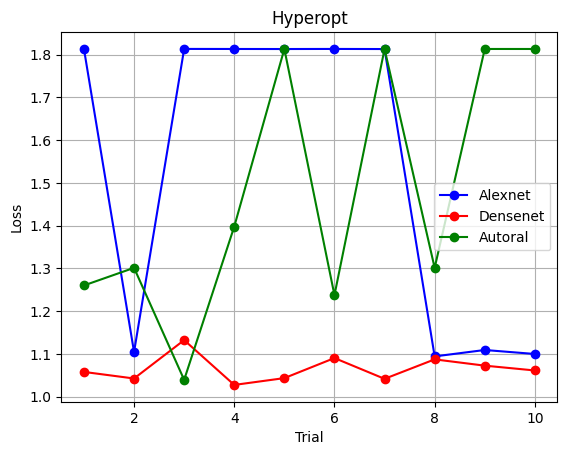

In [21]:
plotar_hyperopt(trials_alexnet,trials_densenet,trials_autoral)

## Alexnet 
- Acurária x Epoca
- Loss x Epoca

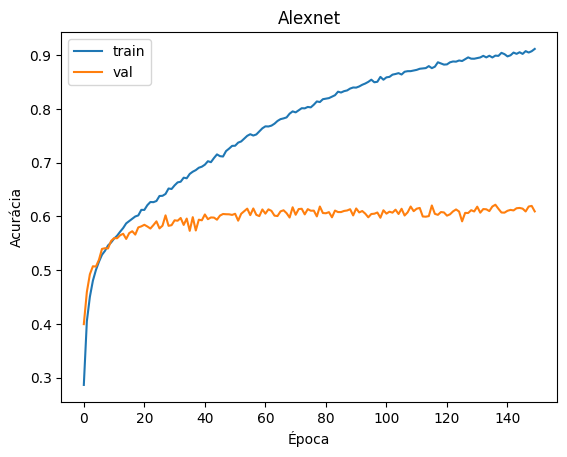

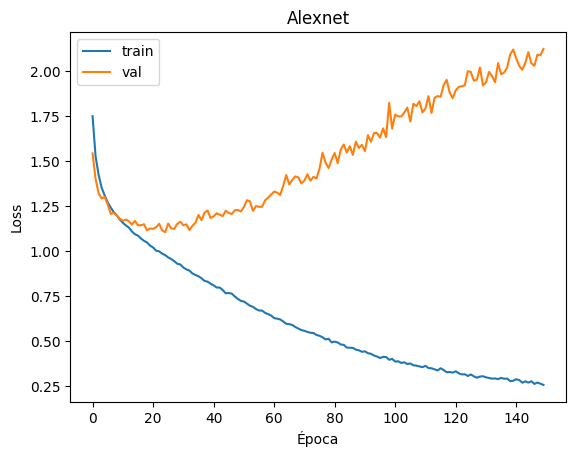

In [22]:
plotar_acc_epoch(history_alexnet.history,"Alexnet")
plotar_loss_epoch(history_alexnet.history,"Alexnet")

## Densenet
- Acurária x Epoca
- Loss x Epoca

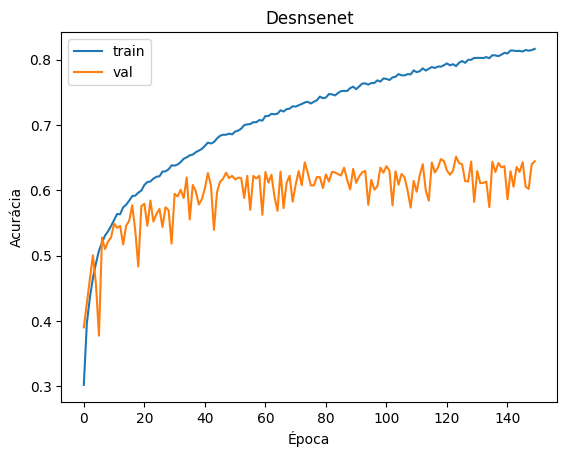

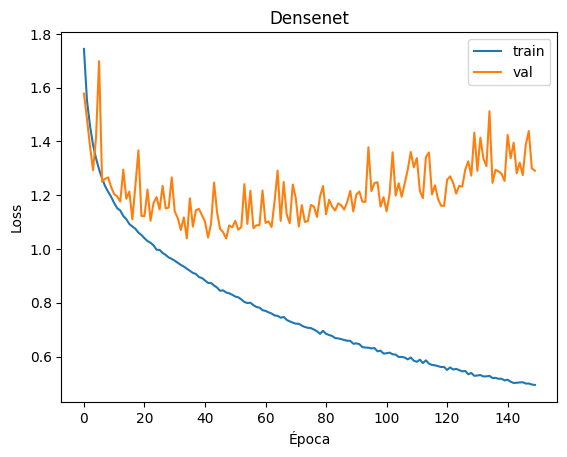

In [23]:
plotar_acc_epoch(history_densenet.history,"Desnsenet")
plotar_loss_epoch(history_densenet.history,"Densenet")

## Autoral
- Acurária x Epoca
- Loss x Epoca

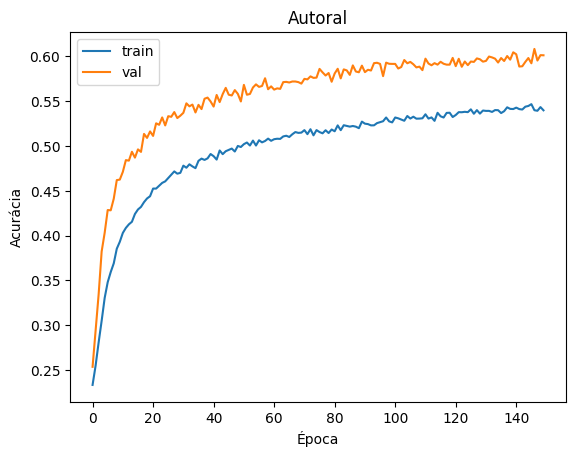

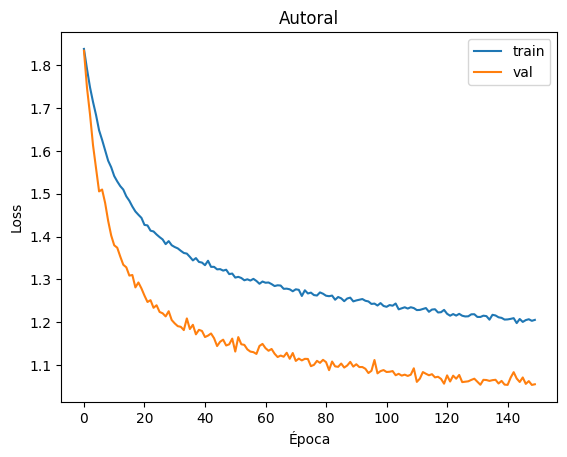

In [24]:
plotar_acc_epoch(history_autoral.history,"Autoral")
plotar_loss_epoch(history_autoral.history,"Autoral")
plotar_matriz_confusao(model_autoral,"Autoral")